# Bike-count interpolation: Euclidean GP vs Graph GP (single-hour snapshot)

This notebook implements two comparable spatial interpolation analyses on the same single-hour snapshot:

1. Euclidean GP (baseline): Matérn/RBF kernel on 2D projected coordinates.
2. Graph GP (paper-style): graph Matérn kernel built from the graph Laplacian eigenpairs.

Both models:
- use the same snapshot time,
- use the same train/test split over sensor nodes,
- predict the same target (bike counts),
- are evaluated with the same metrics and plots.

Important: This is not a temporal model. We intentionally freeze time to one hour.



In [1]:
print("kernel alive")

kernel alive


In [2]:
# Core imports
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import osmnx as ox
import networkx as nx

import scipy.sparse as sp
from scipy.sparse.linalg import eigsh
import scipy.linalg as la
from scipy.optimize import minimize

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, RBF, WhiteKernel, ConstantKernel
from sklearn.metrics import mean_absolute_error, mean_squared_error

# allow imports from src/
import sys
from pathlib import Path
PROJECT_ROOT = Path("..").resolve()
sys.path.append(str(PROJECT_ROOT))

from src.plotting.styles import get_style

# Your project loader (as in your existing notebook)
from src.data.dataload import load_csv_folder_to_dataframe



## 1) Load & preprocess bike counter data

Assumptions:
- Raw CSVs live in `DATA_DIR`
- Columns include:
  - `domain_name` (e.g., 'Stadt Tübingen')
  - `counter_site` (counter ID)
  - `iso_timestamp` (timestamp)
  - `channels_all` (bike count)
  - `latitude`, `longitude` (counter location)



In [3]:
from pathlib import Path

DATA_DIR = PROJECT_ROOT / "data/raw"   # adjust if needed
DOMAIN = "Stadt Ludwigsburg"

SNAPSHOT_TS = pd.Timestamp('2024-10-31 16:00:00+00:00')  # must exist after flooring to hour

df_all_path = PROJECT_ROOT / "data/processed/df_all.csv"

if df_all_path.exists():
    print("Loading cached dataframe from df_all.csv")
    df_loaded = pd.read_csv(df_all_path)
else:
    print("df_all.csv not found, loading raw CSV folder")
    df_loaded = load_csv_folder_to_dataframe(DATA_DIR)
    df_loaded.to_csv(df_all_path, index=False)


df_city = df_loaded[df_loaded["domain_name"] == DOMAIN].copy()
df_city["iso_timestamp"] = pd.to_datetime(df_city["iso_timestamp"], errors="coerce")
df_city = df_city.dropna(subset=["iso_timestamp"])

df_city_small = df_city[["counter_site", "iso_timestamp", "channels_all", "latitude", "longitude"]].copy()

# Freeze time to one hour:
df_city_small["ts_hour"] = df_city_small["iso_timestamp"].dt.floor("H")
df_snapshot = df_city_small[df_city_small["ts_hour"] == SNAPSHOT_TS].copy()

if df_snapshot.empty:
    raise ValueError(
        f"No rows found for SNAPSHOT_TS={SNAPSHOT_TS}. "
        "Pick a timestamp that exists in the data (after flooring to hour)."
    )

# Aggregate within the hour per counter (in case multiple rows exist)
df_obs = (
    df_snapshot
    .groupby("counter_site", as_index=False)
    .agg(
        y=("channels_all", "mean"),
        lat=("latitude", "first"),
        lon=("longitude", "first"),
    )
)

display(df_obs.head())
print("Observed counters in this snapshot:", len(df_obs))



Loading cached dataframe from df_all.csv


/var/folders/dn/vxwn6zk17qg5wl81t01zs03w0000gn/T/ipykernel_3096/4152500721.py:26: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_city_small["ts_hour"] = df_city_small["iso_timestamp"].dt.floor("H")


,counter_site,y,lat,lon
0,Aldinger Straße,24.0,48.883139,9.210566
1,Alleenstraße,150.0,48.893189,9.192943
2,Bismarckstraße,60.0,48.899039,9.181309
3,Bottwartalstraße,58.0,48.903483,9.198207
4,Friedrich-Ebert-Straße,141.0,48.893033,9.206430


Observed counters in this snapshot: 15


In [4]:
# REMOVE this later: Selecting available timestamps

# Ensure timestamps are parsed
df_loaded["iso_timestamp"] = pd.to_datetime(df_loaded["iso_timestamp"], errors="coerce")

# Floor to hour exactly as in the pipeline
df_loaded["ts_hour"] = df_loaded["iso_timestamp"].dt.floor("H")

# Restrict to your domain
df_city = df_loaded[df_loaded["domain_name"] == DOMAIN]

# List unique hours, sorted
unique_hours = (
    df_city["ts_hour"]
    .dropna()
    .sort_values()
    .unique()
)

print("Number of unique hourly snapshots:", len(unique_hours))
print("First 10:", unique_hours[:10])
print("Last 10:", unique_hours[-10:])


/var/folders/dn/vxwn6zk17qg5wl81t01zs03w0000gn/T/ipykernel_3096/1601258778.py:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_loaded["ts_hour"] = df_loaded["iso_timestamp"].dt.floor("H")


Number of unique hourly snapshots: 70852
First 10: <DatetimeArray>
['2017-09-26 22:00:00+00:00', '2017-09-27 06:00:00+00:00',
 '2017-09-27 07:00:00+00:00', '2017-09-27 08:00:00+00:00',
 '2017-09-27 09:00:00+00:00', '2017-09-27 10:00:00+00:00',
 '2017-09-27 11:00:00+00:00', '2017-09-27 12:00:00+00:00',
 '2017-09-27 13:00:00+00:00', '2017-09-27 14:00:00+00:00']
Length: 10, dtype: datetime64[ns, UTC]
Last 10: <DatetimeArray>
['2025-10-31 12:00:00+00:00', '2025-10-31 13:00:00+00:00',
 '2025-10-31 14:00:00+00:00', '2025-10-31 15:00:00+00:00',
 '2025-10-31 16:00:00+00:00', '2025-10-31 17:00:00+00:00',
 '2025-10-31 18:00:00+00:00', '2025-10-31 19:00:00+00:00',
 '2025-10-31 20:00:00+00:00', '2025-10-31 21:00:00+00:00']
Length: 10, dtype: datetime64[ns, UTC]


## 2) Build the road/bike graph and map counters to nearest graph nodes

We:
1. Build an OSMnx bike graph within a radius.
2. Map each counter coordinate to the nearest graph node.
3. Project the graph to a metric CRS for Euclidean-distance kernels.



In [5]:
from osmnx import simplify_graph

GRAPH_RADIUS_M = 3200  # adjust to cover all counters you care about

center = (df_obs["lat"].mean(), df_obs["lon"].mean())

# Build graph in lat/lon
G_ll = ox.graph_from_point(center, dist=GRAPH_RADIUS_M, network_type="bike")

# Keep the largest strongly connected component (helps with graph kernels/distances)
largest_scc = max(nx.strongly_connected_components(G_ll), key=len)
G_ll = G_ll.subgraph(largest_scc).copy()

# Map each counter to nearest node in the lat/lon graph
df_obs["node_id"] = df_obs.apply(
    lambda r: ox.distance.nearest_nodes(G_ll, X=r["lon"], Y=r["lat"]),
    axis=1
)

# Drop counters that map outside the graph (rare, but can happen near boundary)
df_obs = df_obs[df_obs["node_id"].isin(G_ll.nodes)].copy()
print("Counters kept after node mapping:", len(df_obs))

# Project graph to metric CRS (UTM). Node IDs remain the same.
G = ox.project_graph(G_ll)
print("Projected CRS:", G.graph.get("crs"))

# protect train & test nodes BEFORE simplification
protect_nodes = set(df_obs["node_id"])

# Projected node coordinates (meters)
node_xy = pd.DataFrame(
    {
        "node_id": list(G.nodes()),
        "x": [G.nodes[n]["x"] for n in G.nodes()],
        "y": [G.nodes[n]["y"] for n in G.nodes()],
    }
)

df_obs = df_obs.merge(node_xy, on="node_id", how="left")
display(df_obs.head())

# check how many nodes the graph has
print("Number of nodes in the graph:", len(G.nodes()))



Counters kept after node mapping: 15
Projected CRS: EPSG:32632


,counter_site,y_x,lat,lon,node_id,x,y_y
0,Aldinger Straße,24.0,48.883139,9.210566,272590518,515429.354398,5.414494e+06
1,Alleenstraße,150.0,48.893189,9.192943,9512032494,514139.679042,5.415629e+06
2,Bismarckstraße,60.0,48.899039,9.181309,271705119,513280.230178,5.416274e+06
3,Bottwartalstraße,58.0,48.903483,9.198207,135036403,514528.961602,5.416742e+06
4,Friedrich-Ebert-Straße,141.0,48.893033,9.206430,5165758557,515158.304360,5.415573e+06


Number of nodes in the graph: 6776


## 3) One fixed train/test split over observed counters

This split is reused for both models to ensure a fair comparison.



In [6]:
RANDOM_SEED = 46
N_TRAIN = 13  # paper uses 250; we have fewer counters

rng = np.random.default_rng(RANDOM_SEED)

n_obs = len(df_obs)
if n_obs < 4:
    raise ValueError(f"Need at least 4 observed counters for a meaningful split, got {n_obs}.")

n_train = min(N_TRAIN, n_obs - 1)  # keep at least 1 test point
train_rows = rng.choice(n_obs, size=n_train, replace=False)
is_train = np.zeros(n_obs, dtype=bool)
is_train[train_rows] = True

train_df = df_obs.iloc[is_train].copy()
test_df  = df_obs.iloc[~is_train].copy()

print(f"Train counters: {len(train_df)} | Test counters: {len(test_df)}")

print(df_obs.columns)
display(df_obs.head())

y_train = train_df["y_x"].to_numpy(dtype=float)
y_test  = test_df["y_x"].to_numpy(dtype=float)

# standardize the targets (important for GP optimization)
y_mean = y_train.mean()
y_std  = y_train.std()

y_train_std = (y_train - y_mean) / y_std
y_test_std  = (y_test  - y_mean) / y_std



Train counters: 13 | Test counters: 2
Index(['counter_site', 'y_x', 'lat', 'lon', 'node_id', 'x', 'y_y'], dtype='object')


,counter_site,y_x,lat,lon,node_id,x,y_y
0,Aldinger Straße,24.0,48.883139,9.210566,272590518,515429.354398,5.414494e+06
1,Alleenstraße,150.0,48.893189,9.192943,9512032494,514139.679042,5.415629e+06
2,Bismarckstraße,60.0,48.899039,9.181309,271705119,513280.230178,5.416274e+06
3,Bottwartalstraße,58.0,48.903483,9.198207,135036403,514528.961602,5.416742e+06
4,Friedrich-Ebert-Straße,141.0,48.893033,9.206430,5165758557,515158.304360,5.415573e+06


In [7]:
display(df_obs)

,counter_site,y_x,lat,lon,node_id,x,y_y
0,Aldinger Straße,24.0,48.883139,9.210566,272590518,515429.354398,5.414494e+06
1,Alleenstraße,150.0,48.893189,9.192943,9512032494,514139.679042,5.415629e+06
2,Bismarckstraße,60.0,48.899039,9.181309,271705119,513280.230178,5.416274e+06
3,Bottwartalstraße,58.0,48.903483,9.198207,135036403,514528.961602,5.416742e+06
4,Friedrich-Ebert-Straße,141.0,48.893033,9.206430,5165758557,515158.304360,5.415573e+06
5,Fuchshof,62.0,48.890275,9.219911,269466187,516189.086309,5.415291e+06
6,Kesseläcker (Verl. Nussackerweg),18.0,48.901772,9.171905,277767167,512599.071543,5.416559e+06
7,Königinallee,34.0,48.884836,9.206656,9006691822,515170.192129,5.414693e+06
8,Marbacher Straße - Favoritepark,99.0,48.902492,9.195814,9087901877,514351.113718,5.416638e+06
9,Marbacher Straße - Neckarbrücke,21.0,48.907326,9.219096,2070675484,516046.407403,5.417173e+06


## 4) Model A: Euclidean GP on projected coordinates

Input:
- X = (x, y) projected meters

Target:
- y = bike count at the chosen snapshot hour



In [8]:
print("train_df columns:", list(train_df.columns))
print("df_obs columns:", list(df_obs.columns))
print("node_xy columns:", list(node_xy.columns))


train_df columns: ['counter_site', 'y_x', 'lat', 'lon', 'node_id', 'x', 'y_y']
df_obs columns: ['counter_site', 'y_x', 'lat', 'lon', 'node_id', 'x', 'y_y']
node_xy columns: ['node_id', 'x', 'y']


In [9]:
X_train_euc = train_df[["x", "y_y"]].to_numpy(dtype=float)
X_test_euc  = test_df[["x", "y_y"]].to_numpy(dtype=float)

# Kernel: Constant * Matérn + White noise, all standard initialization (data is standardized!)
kernel_euc = (
    ConstantKernel() *
    Matern(nu=1.5) +   
    WhiteKernel()
)

gp_euc = GaussianProcessRegressor(
    kernel=kernel_euc,
    alpha=0.0,
    normalize_y=True,   # already standardized
    n_restarts_optimizer=5,
    random_state=RANDOM_SEED
)

gp_euc.fit(X_train_euc, y_train)

pred_mean_euc, pred_std_euc = gp_euc.predict(X_test_euc, return_std=True)

rmse_euc = np.sqrt(mean_squared_error(y_test, pred_mean_euc))
mae_euc  = mean_absolute_error(y_test, pred_mean_euc)


print("Euclidean GP kernel after fit:")
print(gp_euc.kernel_)
print(f"Euclidean GP  RMSE={rmse_euc:.3f}  MAE={mae_euc:.3f}")



Euclidean GP kernel after fit:
0.667**2 * Matern(length_scale=607, nu=1.5) + WhiteKernel(noise_level=0.569)
Euclidean GP  RMSE=16.851  MAE=13.036


## 5) Model B: Graph GP on the network

### 5.1) Build Laplacian and compute Eigenpairs
We build a weighted adjacency W:
- edge weight = inverse edge length (paper-style)

Then the normalized symmetric Laplacian:
- $L_{sym} = I - D^{-1/2} W D^{-1/2}$

We approximate the graph kernel with the smallest RANK eigenpairs of L_sym (we chose the lowest 5%).



In [10]:
# build node indexing
nodes = list(G.nodes())
node_to_idx = {n: i for i, n in enumerate(nodes)}
n_nodes = len(nodes)

# weighted adjacency W
rows, cols, data = [], [], []
for u, v, attr in G.edges(data=True):
    length = attr.get("length", None)
    if length is None or length <= 0:
        continue
    w = 1.0 / float(length) ## inverse length weight
    iu, iv = node_to_idx[u], node_to_idx[v]
    rows += [iu, iv]
    cols += [iv, iu]
    data += [w, w]

# construct sparse adjacency matrix
W = sp.coo_matrix((data, (rows, cols)), shape=(n_nodes, n_nodes)).tocsr()
deg = np.asarray(W.sum(axis=1)).ravel()
D_inv_sqrt = sp.diags(np.where(deg > 0, 1.0 / np.sqrt(deg), 0.0))

# normalized symmetric graph laplacian
L_sym = sp.eye(n_nodes, format="csr") - D_inv_sqrt @ W @ D_inv_sqrt

# compute eigenpairs
RANK = min(int(np.floor(0.05 * len(G.nodes()))), n_nodes - 2) ## 5% of nodes
evals, evecs = eigsh(L_sym, k=RANK, which="SM")
evals = np.maximum(evals, 0.0)

print("Eigenpairs computed:", evecs.shape)


Eigenpairs computed: (6776, 338)


### 5.2) Build Kernel Filters (Matérn & Laplacian) & optimize Hyperparameters using GP Marginal Likelihood

Graph Diffusion filter:
- $\Phi(\lambda) = \exp(-\frac{\kappa^2}{4}\lambda)$

Graph Matérn spectral filter:
- $\Phi(\lambda) = (\frac{2\nu}{\kappa^2}+\lambda)^{-\nu}$
We keep $\nu$ fixed (you can change it).
Graph Matérn spectral filter did not yield any good results so we took diffusion (maybe due to very few training data).

We optimize hyperparameters by maximizing the GP marginal likelihood:
- $\kappa$ (length scale on the graph)
- $\sigma^2$ (variance)
- $\varsigma^2$ (noise variance)

When freely optimizing all 3 parameters $\sigma^2 \rightarrow 0$, so we settled on fixing it to 1 and optimizing only $\kappa$ and $\varsigma^2$.

MAYBE PUT ALL THE K = ZZt up here because Marginal Likelihood uses it? idk

In [11]:
# indices for training/test nodes
train_node_idx = np.array([node_to_idx[n] for n in train_df["node_id"]], dtype=int)
test_node_idx  = np.array([node_to_idx[n] for n in test_df["node_id"]], dtype=int)

# diffusion kernel feature matrix
def build_Z(kappa: float, sigma2: float) -> np.ndarray:
    
    phi = np.exp(-(kappa**2/4.0) * evals)
    
    Z = (evecs * np.sqrt(phi)[None, :]) * np.sqrt(sigma2)
    return Z

# matern kernel feature matrix (this does not work as well as diffusion)
nu_fixed = 1.5
def build_Z_matern(kappa: float, sigma2: float, nu: float) -> np.ndarray:
    
    phi = (2.0 * nu / (kappa**2) + evals) ** (-nu)
    
    Z = evecs * np.sqrt(phi)[None, :] * np.sqrt(sigma2)
    return Z



In [12]:
## NEGATIVE LOG MARGINAL LIKELIHOOD OPTIMIZATION ##
# define nll optimization for all 3 parameters
def neg_log_marginal_likelihood(params_log: np.ndarray) -> float:
    # params_log = [log_kappa, log_sigma2, log_noise_std]
    log_kappa, log_sigma2, log_noise = params_log
    kappa = np.exp(log_kappa)
    sigma2 = np.exp(log_sigma2)
    noise = np.exp(log_noise)

    Z = build_Z(kappa, sigma2)
    Ztr = Z[train_node_idx, :]

    K = Ztr @ Ztr.T
    K[np.diag_indices_from(K)] += noise**2 + 1e-8

    try:
        L = la.cholesky(K, lower=True, check_finite=False)
    except la.LinAlgError:
        return np.inf

    alpha = la.cho_solve((L, True), y_train_std, check_finite=False)

    n = len(y_train_std)
    nll = 0.5 * (y_train_std @ alpha) + np.sum(np.log(np.diag(L))) + 0.5 * n * np.log(2*np.pi)
    return float(nll)

# define nll optimization for kappa only, fixing sigma2 and noise
sigma2_fixed = 1.0
noise_fixed = 0.3
def nll_only_kappa(log_kappa):
    kappa = np.exp(log_kappa[0])

    Z = build_Z(kappa, sigma2_fixed)
    Ztr = Z[train_node_idx]

    K = Ztr @ Ztr.T
    K[np.diag_indices_from(K)] += noise_fixed**2 + 1e-8

    try:
        L = la.cholesky(K, lower=True, check_finite=False)
    except la.LinAlgError:
        return np.inf

    alpha = la.cho_solve((L, True), y_train_std, check_finite=False)

    n = len(y_train_std)
    nll = 0.5 * (y_train_std @ alpha) + np.sum(np.log(np.diag(L))) + 0.5 * n * np.log(2*np.pi)
    return float(nll)


# define nll optimization for kappa and noise, fixing sigma2
def nll_kappa_noise(log_params):
    log_kappa, log_noise = log_params
    kappa = np.exp(log_kappa)
    noise = np.exp(log_noise)

    Z = build_Z(kappa, sigma2_fixed)
    Ztr = Z[train_node_idx, :]

    K = Ztr @ Ztr.T
    K[np.diag_indices_from(K)] += noise**2 + 1e-8

    try:
        L = la.cholesky(K, lower=True, check_finite=False)
    except la.LinAlgError:
        return np.inf

    alpha = la.cho_solve((L, True), y_train_std, check_finite=False)

    n = len(y_train_std)
    nll = 0.5 * (y_train_std @ alpha) + np.sum(np.log(np.diag(L))) + 0.5 * n * np.log(2*np.pi)
    return float(nll)

# optimize all 3 parameters
x0 = np.log([0.03, 1.0, 0.1])
res_3param = minimize(neg_log_marginal_likelihood, x0=x0, method="L-BFGS-B", options={"maxiter": 500})
print("Optimization success:", res_3param.success, "|", res_3param.message)
kappa_hat3p, sigma2_hat3p, noise_hat3p = np.exp(res_3param.x)
print(f"Fitted graph GP params for all 3 params: kappa={kappa_hat3p:.4g}, sigma2={sigma2_hat3p:.4g}, noise_std={noise_hat3p:.4g}")

# optimize kappa only
res_1param = minimize(nll_only_kappa, x0=np.log([0.03]), method="L-BFGS-B", options={"maxiter": 500})
print("Optimization success:", res_1param.success, "|", res_1param.message)
kappa_hat1p = np.exp(res_1param.x[0])
print(f"Fitted graph GP params for 1 param: kappa={kappa_hat1p:.4g}, sigma2={sigma2_fixed:.4g}, noise_std={noise_fixed:.4g}")

# optimize kappa and noise
# Define bounds in log-space to keep parameters in reasonable ranges
bounds_2param = [
    (np.log(0.001), np.log(0.5)),   # kappa: 0.001 to 0.5
    (np.log(0.01), np.log(5.0))     # noise: 0.01 to 5.0
]

# print inital NLL
x0=np.log([0.03, 0.5])
print("inital NLL",nll_kappa_noise(x0))
res_2param = minimize(nll_kappa_noise, x0=np.log([0.03, 0.5]), method="L-BFGS-B", bounds=bounds_2param, options={"maxiter": 500})
print("final NLL", res_2param.fun)
print("Optimization success:", res_2param.success, "|", res_2param.message)
kappa_hat2p, noise_hat2p = np.exp(res_2param.x)
print(f"Fitted graph GP params for 2 params: kappa={kappa_hat2p:.4g}, sigma2={sigma2_fixed:.4g}, noise_std={noise_hat2p:.4g}")



Optimization success: True | CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
Fitted graph GP params for all 3 params: kappa=0.03, sigma2=2.059e-05, noise_std=1
Optimization success: True | CONVERGENCE: NORM OF PROJECTED GRADIENT <= PGTOL
Fitted graph GP params for 1 param: kappa=0.01104, sigma2=1, noise_std=0.3
inital NLL 27.643417370317483
final NLL 18.50623699410117
Optimization success: True | CONVERGENCE: NORM OF PROJECTED GRADIENT <= PGTOL
Fitted graph GP params for 2 params: kappa=0.03, sigma2=1, noise_std=0.9934


### 5.3) Prediction on Test Nodes

We use optimized $\kappa, \varsigma^2$ and fixed $\sigma^2$ to compute the Diffusion Kernel Feature Matrix $Z$.

Next, compute low rank approximation of Kernel

$K_{xx} \approx Z_xZ_x^\top$
where
$Z_x = \sqrt{\sigma^2} \, U \, \sqrt{\Phi(\Lambda)}$

Here, $U$ are the eigenvectors of the graph Laplacian $\Delta$, $\Lambda = \text{diag}(\lambda_1, \dots, \lambda_R)$ are the corresponding eigenvalues, and the spectral weights are defined as
- $\Phi(\lambda_s) = \exp\Big(-\frac{\kappa^2}{4} \lambda_s \Big), \quad s = 1, \dots, R$

So the low-rank kernel approximation can be written as
- $K_{xx} \approx Z Z^\top = \sigma^2 \, U \, \Phi(\Lambda) \, U^\top$
with $\sigma^2 = 1$

For prediction we need to solve for
- $\alpha = (K_{xx} + \varsigma^2I)^{-1}y_{train}$

Since $K_{xx}$ is small ($13 \times 13$) in our case, we compute $\alpha$ efficiently using a Cholesky decomposition:
- $K_{xx} + \varsigma^2 I = L L^\top, \quad \alpha = L^{-\top} (L^{-1} y_{\text{train}})$


The predictive mean can be computed as:
- $\mu_* = (K_{*x} \alpha)y_{sd} + y_{mean}$ with $K_{*x} = Z_*Z_x^\top$

The predictive variance (latent) can be computed as:
- $\mathrm{Var}[f_*] = \mathrm{diag}(K_{**}) - \mathrm{diag}\Big( K_{*x} (K_{xx} + \sigma_n^2 I)^{-1} K_{*x}^\top \Big)$,

where $K_{**} = Z_* Z_*^\top$ is the kernel matrix at test nodes. Using the Cholesky decomposition $K_{xx} + \sigma_n^2 I = L L^\top$, this can be efficiently computed as
- $v = L^{-1} K_{*x}^\top, \qquad
\mathrm{Var}[f_*] \approx \sum_{s=1}^d (Z_{*s})^2 - \sum_{s=1}^R v_s^2$

The predictive standard deviation can be computed as:
- $\sigma_* = (\mathrm{Var}[f_*]+ \varsigma^2) y_{sd}$



In [13]:
# Predict on test nodes
kappa = kappa_hat2p ## this is for 2 fixed params, choose kappa = kappa_hat1p or kappa_hat3p for other options
sigma2 = sigma2_fixed ## this is fixed for 1 and 2 param options, choose sigma2 = sigma2_hat3p for 3 param option
noise = noise_hat2p ## this is for 2 fixed params, choose noise = noise_hat3p for 3 param option or noise = noise_fixed for 1 param option
Z = build_Z(kappa, sigma2)
Ztr = Z[train_node_idx, :]
Zte = Z[test_node_idx, :]

# build Ktr (Kxx)
Ktr = Ztr @ Ztr.T
# Kxx += σₙ²I
Ktr[np.diag_indices_from(Ktr)] += noise**2 + 1e-8

L = la.cholesky(Ktr, lower=True, check_finite=False)
alpha = la.cho_solve((L, True), y_train_std, check_finite=False)
# alpha = (Kxx + σₙ² I)⁻¹ y 

# build Kte_tr (Kx*)
Kte_tr = Zte @ Ztr.T

# predictive mean
pred_mean_graph_std = Kte_tr @ alpha

# predictive varianc
Kte_diag = np.sum(Zte**2, axis=1)
v = la.solve_triangular(L, Kte_tr.T, lower=True, check_finite=False)
pred_var_graph = np.maximum(0.0, Kte_diag - np.sum(v*v, axis=0))
pred_std_graph_std = np.sqrt(pred_var_graph + noise**2)

pred_mean_graph = pred_mean_graph_std * y_std + y_mean
pred_std_graph  = pred_std_graph_std * y_std

rmse_graph = np.sqrt(mean_squared_error(y_test, pred_mean_graph))
mae_graph  = mean_absolute_error(y_test, pred_mean_graph)


print(f"Graph GP      RMSE={rmse_graph:.3f}  MAE={mae_graph:.3f}")



Graph GP      RMSE=19.390  MAE=14.016


## 6) Comparison plots (test nodes)



/var/folders/dn/vxwn6zk17qg5wl81t01zs03w0000gn/T/ipykernel_3096/1104866370.py:11: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


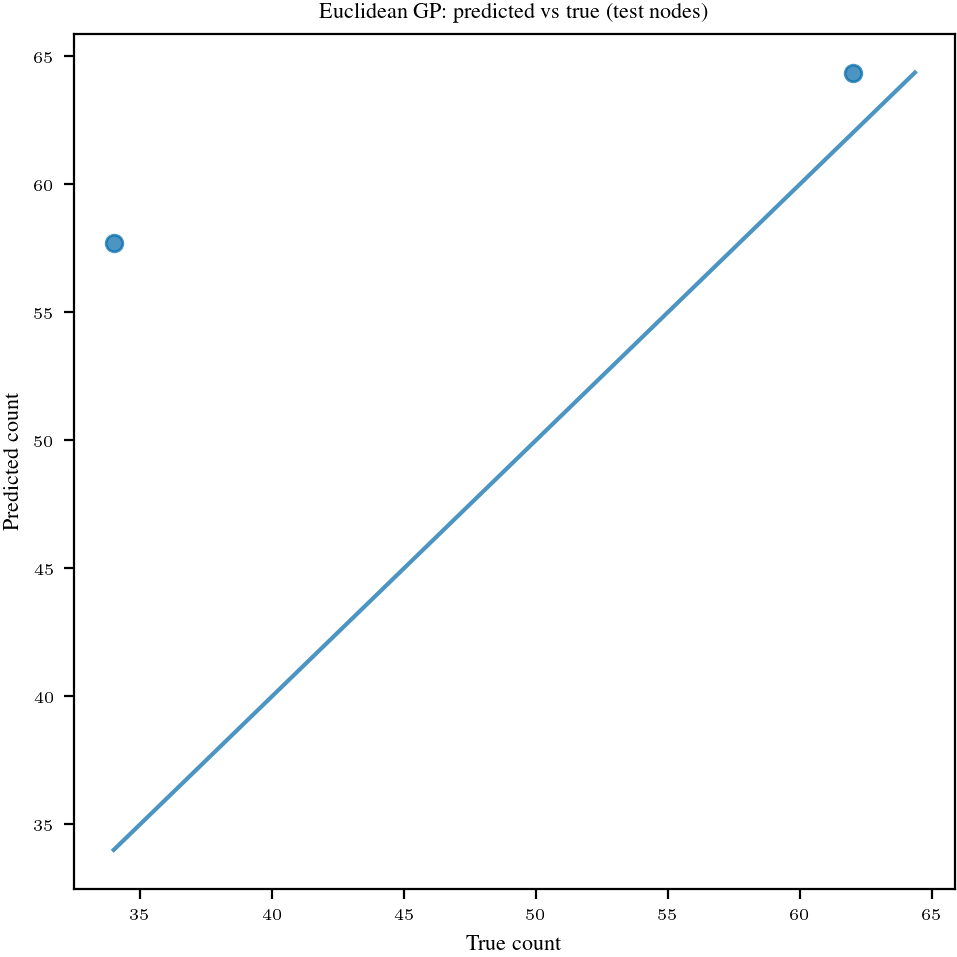

/var/folders/dn/vxwn6zk17qg5wl81t01zs03w0000gn/T/ipykernel_3096/1104866370.py:11: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


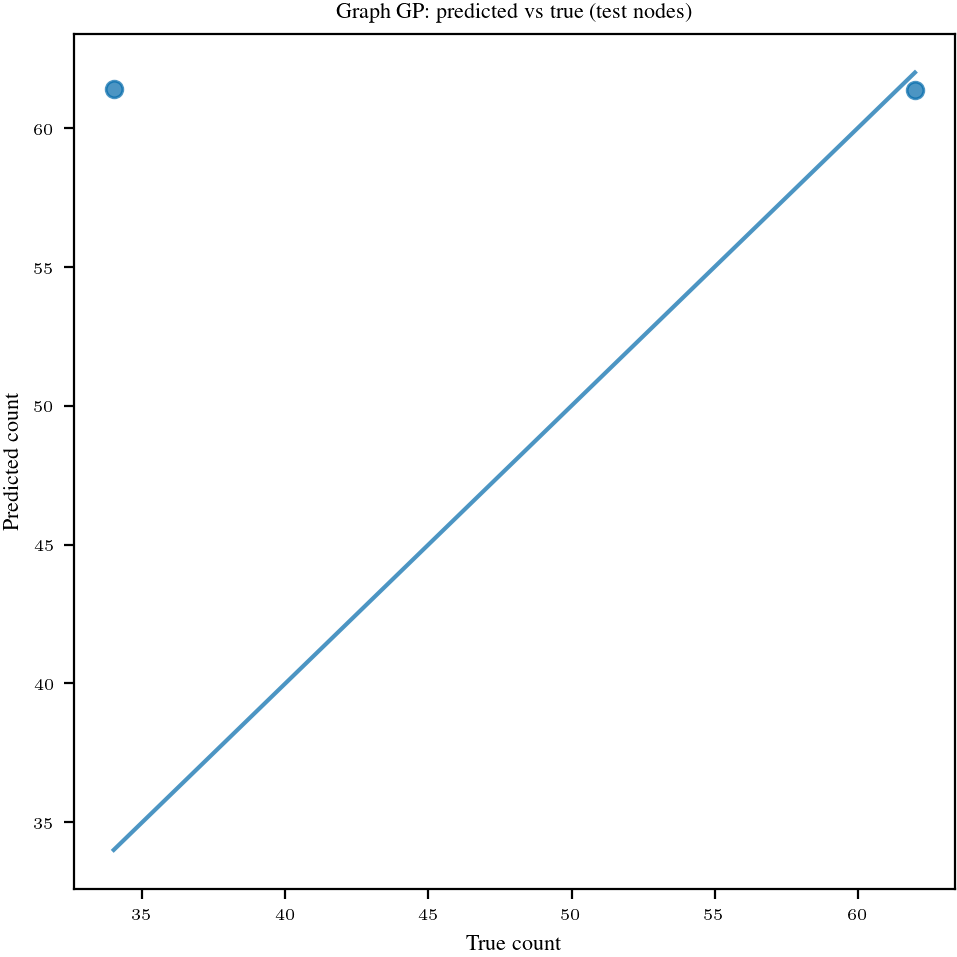

,counter_site,y_y,resid_euc,resid_graph
5,Fuchshof,5.415291e+06,2.359117,-0.617739
7,Königinallee,5.414693e+06,23.713219,27.414676


In [14]:
def scatter_pred_vs_true(y_true, y_pred, title):
    with plt.rc_context(get_style()):
        plt.figure(figsize=(5,5))
        plt.scatter(y_true, y_pred)
        lo = min(y_true.min(), y_pred.min())
        hi = max(y_true.max(), y_pred.max())
        plt.plot([lo, hi], [lo, hi])
        plt.xlabel("True count")
        plt.ylabel("Predicted count")
        plt.title(title)
        plt.tight_layout()
        plt.show()

scatter_pred_vs_true(y_test, pred_mean_euc, "Euclidean GP: predicted vs true (test nodes)")
scatter_pred_vs_true(y_test, pred_mean_graph, "Graph GP: predicted vs true (test nodes)")

test_plot = test_df.copy()
test_plot["resid_euc"] = pred_mean_euc - y_test
test_plot["resid_graph"] = pred_mean_graph - y_test

display(test_plot[["counter_site","y_y","resid_euc","resid_graph"]].head())



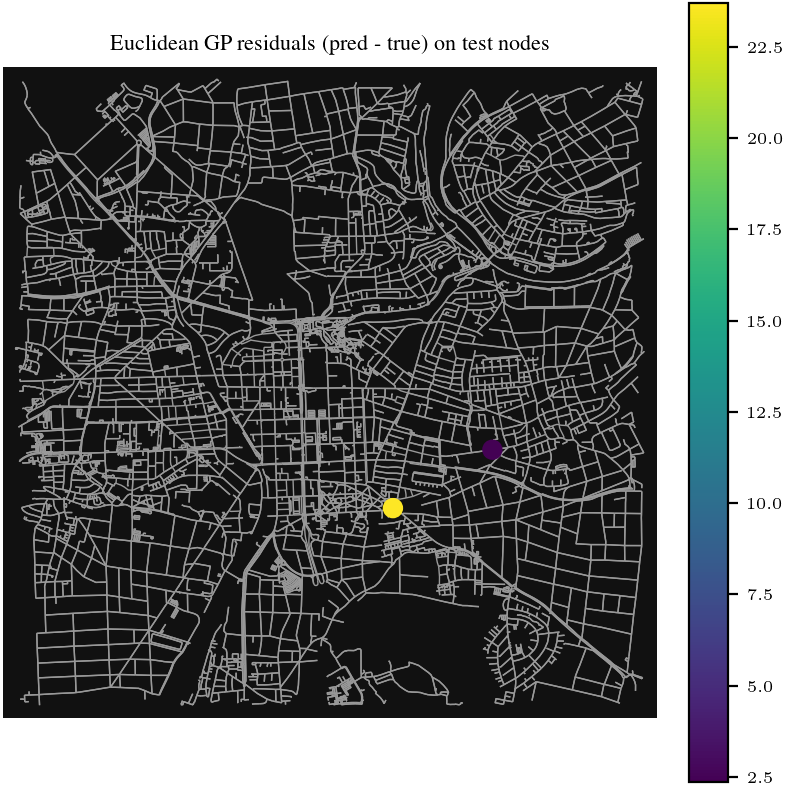

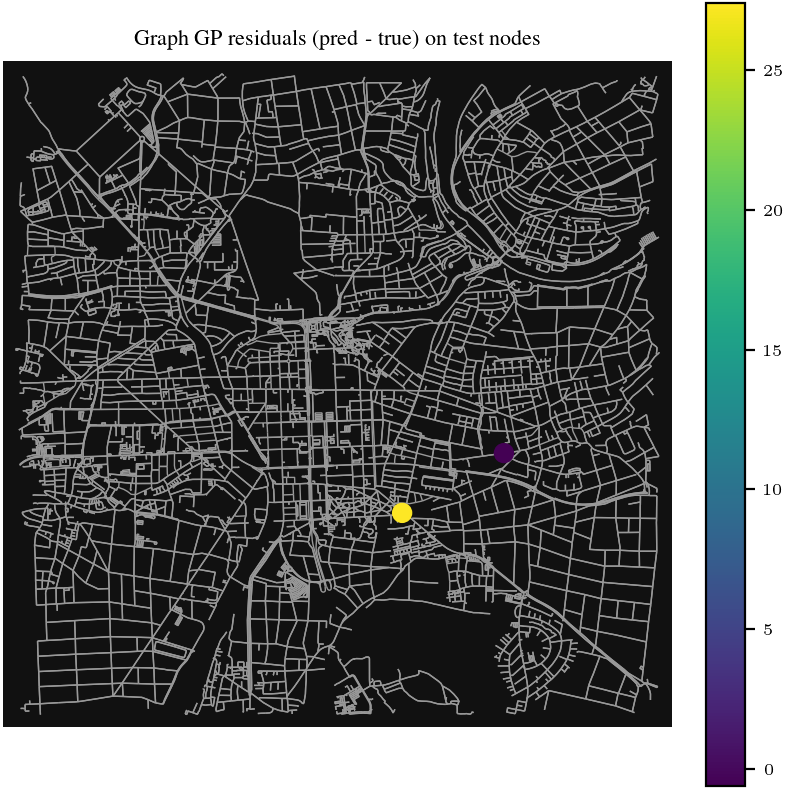

In [15]:
# Residual maps on the graph (test nodes only)
with plt.rc_context(get_style(rel_width=.5)):
    fig, ax = ox.plot_graph(G, show=False, close=False, node_size=0, edge_linewidth=0.5, figsize= (4, 4))
    sc = ax.scatter(test_plot["x"], test_plot["y_y"], c=test_plot["resid_euc"], s=40)
    plt.colorbar(sc, ax=ax)
    ax.set_title("Euclidean GP residuals (pred - true) on test nodes")
    plt.show()

    fig, ax = ox.plot_graph(G, show=False, close=False, node_size=0, edge_linewidth=0.5, figsize=(4, 4))
    sc = ax.scatter(test_plot["x"], test_plot["y_y"], c=test_plot["resid_graph"], s=40)
    plt.colorbar(sc, ax=ax)
    ax.set_title("Graph GP residuals (pred - true) on test nodes")
    plt.show()



## 7) Optional: full-field maps (all nodes)

In 5) we only predicted on our two test nodes. If we want to predict mean and standard deviation on all nodes, we do not use $K_{*x}$ but $K_{all,x}$ (computation is the same as above).

We cannot plot residuals (as we do not have counts on all nodes), but we can plot a general prediction.

In [16]:
# Euclidean GP predictions at all nodes
mean_all_euc, std_all_euc = gp_euc.predict(node_xy[["x","y"]].to_numpy(dtype=float), return_std=True)

# Graph GP predictions at all nodes
all_node_idx = np.array([node_to_idx[n] for n in node_xy["node_id"]], dtype=int)
Zall = Z[all_node_idx, :]
Kall_tr = Zall @ Ztr.T

# predictive mean for all nodes
mean_all_graph = Kall_tr @ alpha

# predictive variance, std for all nodes
Kall_diag = np.sum(Zall**2, axis=1)
vall = la.solve_triangular(L, Kall_tr.T, lower=True, check_finite=False)
var_all_graph = np.maximum(0.0, Kall_diag - np.sum(vall*vall, axis=0))
std_all_graph = np.sqrt(var_all_graph + noise**2)

# prepare dataframe for plotting
node_xy_plot = node_xy.copy()
node_xy_plot["mean_euc"] = mean_all_euc
node_xy_plot["std_euc"] = std_all_euc
node_xy_plot["mean_graph"] = mean_all_graph
node_xy_plot["std_graph"] = std_all_graph

# unstandardize graph GP predictions
node_xy_plot["mean_graph_orig"] = node_xy_plot["mean_graph"] * y_std + y_mean
print(node_xy_plot["mean_graph_orig"].head())
node_xy_plot["std_graph_orig"]  = node_xy_plot["std_graph"] * y_std

0    61.381114
1    61.377858
2    61.381854
3    61.373694
4    61.372203
Name: mean_graph_orig, dtype: float64


### 7.1) Plot predicted Mean

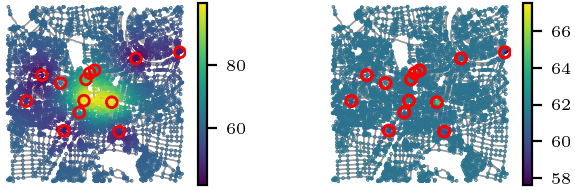

In [17]:
OUTPUT_DIR = PROJECT_ROOT / "outputs/plots/GP"
# plot predicted mean (all nodes)
# both euclidean and graph GP side by side
with plt.rc_context(get_style(ncols=2)):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    
    # Euclidean GP (left)
    ox.plot_graph(G, ax=ax1, show=False, close=False, node_size=0, edge_linewidth=0.5)
    sc1 = ax1.scatter(node_xy_plot["x"], node_xy_plot["y"], c=node_xy_plot["mean_euc"], s=.1)
    ax1.scatter(
        node_xy_plot.iloc[train_node_idx]["x"],
        node_xy_plot.iloc[train_node_idx]["y"],
        facecolors="none",
        edgecolors="red",
        s=15,
        linewidths=1,
        zorder=10
    )
    plt.colorbar(sc1, ax=ax1)
    #ax1.set_title("Euclidean GP: predicted mean (all nodes)")
    
    # Graph GP (right)
    ox.plot_graph(G, ax=ax2, show=False, close=False, node_size=0, edge_linewidth=0.5)
    sc2 = ax2.scatter(node_xy_plot["x"], node_xy_plot["y"], c=node_xy_plot["mean_graph_orig"], s=.1)
    ax2.scatter(
        node_xy_plot.iloc[train_node_idx]["x"],
        node_xy_plot.iloc[train_node_idx]["y"],
        facecolors="none",
        edgecolors="red",
        s=15,
        linewidths=1.2,
        zorder=10
    )
    plt.colorbar(sc2, ax=ax2)
    #ax2.set_title("Graph GP: predicted mean (all nodes)")
    
    #plt.tight_layout()
    # save in outputs/plots/GP folder as pdf
    OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
    plt.savefig(OUTPUT_DIR / "predicted_mean_comparison.pdf", bbox_inches="tight")


    plt.show()


### 7.2) Plot predicted Standard Deviation (Uncertainty)

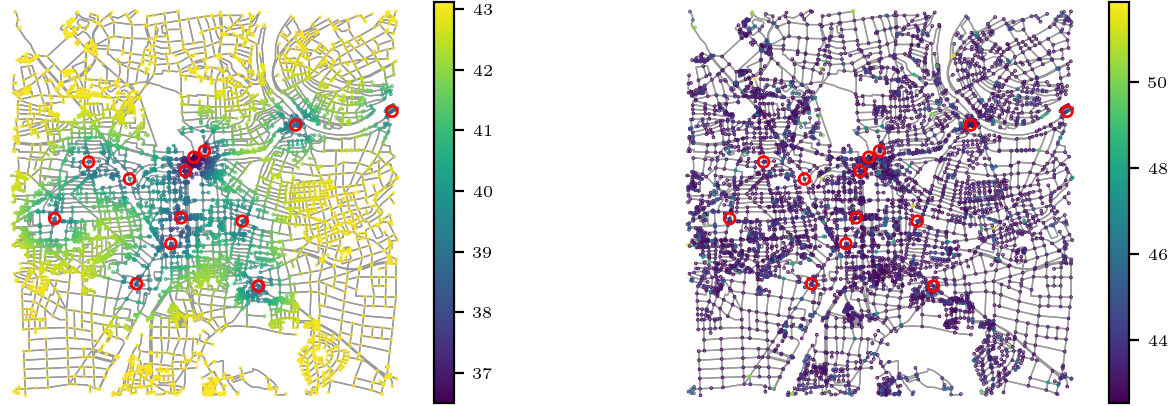

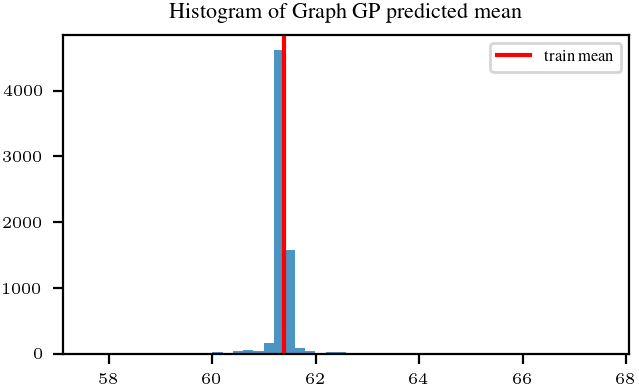

In [18]:
# plot predicted uncertainty (all nodes)
# both euclidean and graph GP side by side
with plt.rc_context(get_style(ncols=2, column='full')):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    
    # Euclidean GP (left)
    ox.plot_graph(G, ax=ax1, show=False, close=False, node_size=0, edge_linewidth=0.5)
    sc1 = ax1.scatter(node_xy_plot["x"], node_xy_plot["y"], c=node_xy_plot["std_euc"], s=.1)
    ax1.scatter(
        node_xy_plot.iloc[train_node_idx]["x"],
        node_xy_plot.iloc[train_node_idx]["y"],
        facecolors="none",
        edgecolors="red",
        s=15,
        linewidths=1,
        zorder=10
    )
    plt.colorbar(sc1, ax=ax1)
    #ax1.set_title("Euclidean GP: predicted std (all nodes)")
    
    # Graph GP (right)
    ox.plot_graph(G, ax=ax2, show=False, close=False, node_size=0, edge_linewidth=0.5)
    sc2 = ax2.scatter(node_xy_plot["x"], node_xy_plot["y"], c=node_xy_plot["std_graph_orig"], s=.1)
    ax2.scatter(
        node_xy_plot.iloc[train_node_idx]["x"],
        node_xy_plot.iloc[train_node_idx]["y"],
        facecolors="none",
        edgecolors="red",
        s=15,
        linewidths=1,
        zorder=10
    )
    plt.colorbar(sc2, ax=ax2)
    #ax2.set_title("Graph GP: predicted std (all nodes)")
    
    #plt.tight_layout()  # conflicts with colorbars
    plt.savefig(OUTPUT_DIR / "predicted_std_comparison.pdf", bbox_inches='tight')
    plt.show()

# histogram of predicted means
with plt.rc_context(get_style()):
    plt.hist(node_xy_plot["mean_graph_orig"], bins=50)
    plt.axvline(y_train.mean(), color="red", label="train mean")
    plt.legend()
    plt.title("Histogram of Graph GP predicted mean")
    plt.show()

### Optional: Top 20 Nodes for Euclidean/ Graph GP

We can also show the nodes with highest uncertainty for both models.

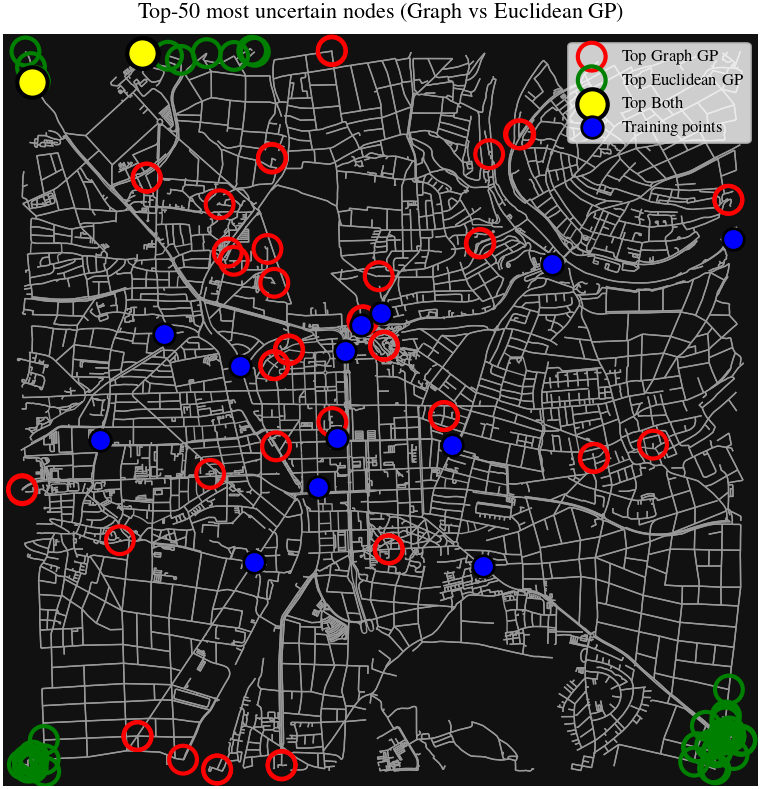

In [19]:
N_top = 50

# top N for Graph GP
top_graph_idx = node_xy_plot["std_graph_orig"].nlargest(N_top).index
top_graph_nodes = node_xy_plot.loc[top_graph_idx]

# top N for Euclidean GP
top_euc_idx = node_xy_plot["std_euc"].nlargest(N_top).index
top_euc_nodes = node_xy_plot.loc[top_euc_idx]

# optional: find common nodes in both top-N lists
common_nodes_idx = top_graph_idx.intersection(top_euc_idx)
common_nodes = node_xy_plot.loc[common_nodes_idx]
with plt.rc_context(get_style()):
    fig, ax = ox.plot_graph(G, show=False, close=False, node_size=0, edge_linewidth=0.5, figsize=(4, 4))

    # graph GP top N nodes
    ax.scatter(
        top_graph_nodes["x"], top_graph_nodes["y"],
        facecolors="none", edgecolors="red",
        s=100, label="Top Graph GP", linewidths=1.5
    )

    # euclidean GP top N nodes
    ax.scatter(
        top_euc_nodes["x"], top_euc_nodes["y"],
        facecolors="none", edgecolors="green",
        s=100, label="Top Euclidean GP", linewidths=1.5
    )

    # common top N nodes
    if not common_nodes.empty:
        ax.scatter(
            common_nodes["x"], common_nodes["y"],
            facecolors="yellow", edgecolors="black",
            s=120, label="Top Both", linewidths=1.5
        )

    # training points as reference
    ax.scatter(
        node_xy_plot.iloc[train_node_idx]["x"],
        node_xy_plot.iloc[train_node_idx]["y"],
        facecolors="blue", edgecolors="black",
        s=60, label="Training points"
    )

    ax.set_title(f"Top-{N_top} most uncertain nodes (Graph vs Euclidean GP)")
    ax.legend(loc="upper right")
    plt.show()


## Leave-Two-Out Cross-Validation

Test all possible leave-two-out combinations for both Euclidean GP and Graph GP models.
For each combination, calculate MAE, RMSE, and MAPE on the held-out test nodes.

## Empirical Analysis: What Does κ Mean?

Let's compute empirical spatial correlations to understand what κ value is reasonable for urban bike counts.

In [20]:
# Compute pairwise graph distances between all observed counters
from itertools import combinations

# Get all pairs of observed counters
counter_pairs = list(combinations(range(len(df_obs)), 2))

# Compute graph distances using shortest path
graph_distances = []
euclidean_distances = []

print(f"Computing pairwise distances for {len(df_obs)} counters...")
print(f"Total pairs: {len(counter_pairs)}\n")

for i, j in counter_pairs:
    # Get node IDs
    node_i = df_obs.iloc[i]["node_id"]
    node_j = df_obs.iloc[j]["node_id"]
    
    # Graph distance (shortest path in meters)
    try:
        graph_dist = nx.shortest_path_length(G, node_i, node_j, weight="length")
        graph_distances.append(graph_dist)
        
        # Euclidean distance
        x_i, y_i = df_obs.iloc[i]["x"], df_obs.iloc[i]["y_y"]
        x_j, y_j = df_obs.iloc[j]["x"], df_obs.iloc[j]["y_y"]
        euc_dist = np.sqrt((x_i - x_j)**2 + (y_i - y_j)**2)
        euclidean_distances.append(euc_dist)
    except nx.NetworkXNoPath:
        # Skip pairs not connected on the graph
        continue

# Convert to arrays
graph_distances = np.array(graph_distances)
euclidean_distances = np.array(euclidean_distances)

print(f"Connected pairs: {len(graph_distances)}")
print(f"\nGraph distance statistics (meters):")
print(f"  Min:    {graph_distances.min():.0f} m")
print(f"  Median: {np.median(graph_distances):.0f} m")
print(f"  Mean:   {graph_distances.mean():.0f} m")
print(f"  Max:    {graph_distances.max():.0f} m")

print(f"\nEuclidean distance statistics (meters):")
print(f"  Min:    {euclidean_distances.min():.0f} m")
print(f"  Median: {np.median(euclidean_distances):.0f} m")
print(f"  Mean:   {euclidean_distances.mean():.0f} m")
print(f"  Max:    {euclidean_distances.max():.0f} m")

print(f"\nGraph vs Euclidean distance ratio:")
print(f"  Median: {np.median(graph_distances / euclidean_distances):.2f}x")
print(f"  Mean:   {np.mean(graph_distances / euclidean_distances):.2f}x")

Computing pairwise distances for 15 counters...
Total pairs: 105

Connected pairs: 105

Graph distance statistics (meters):
  Min:    267 m
  Median: 2453 m
  Mean:   2638 m
  Max:    6744 m

Euclidean distance statistics (meters):
  Min:    206 m
  Median: 2032 m
  Mean:   2188 m
  Max:    5894 m

Graph vs Euclidean distance ratio:
  Median: 1.22x
  Mean:   1.23x


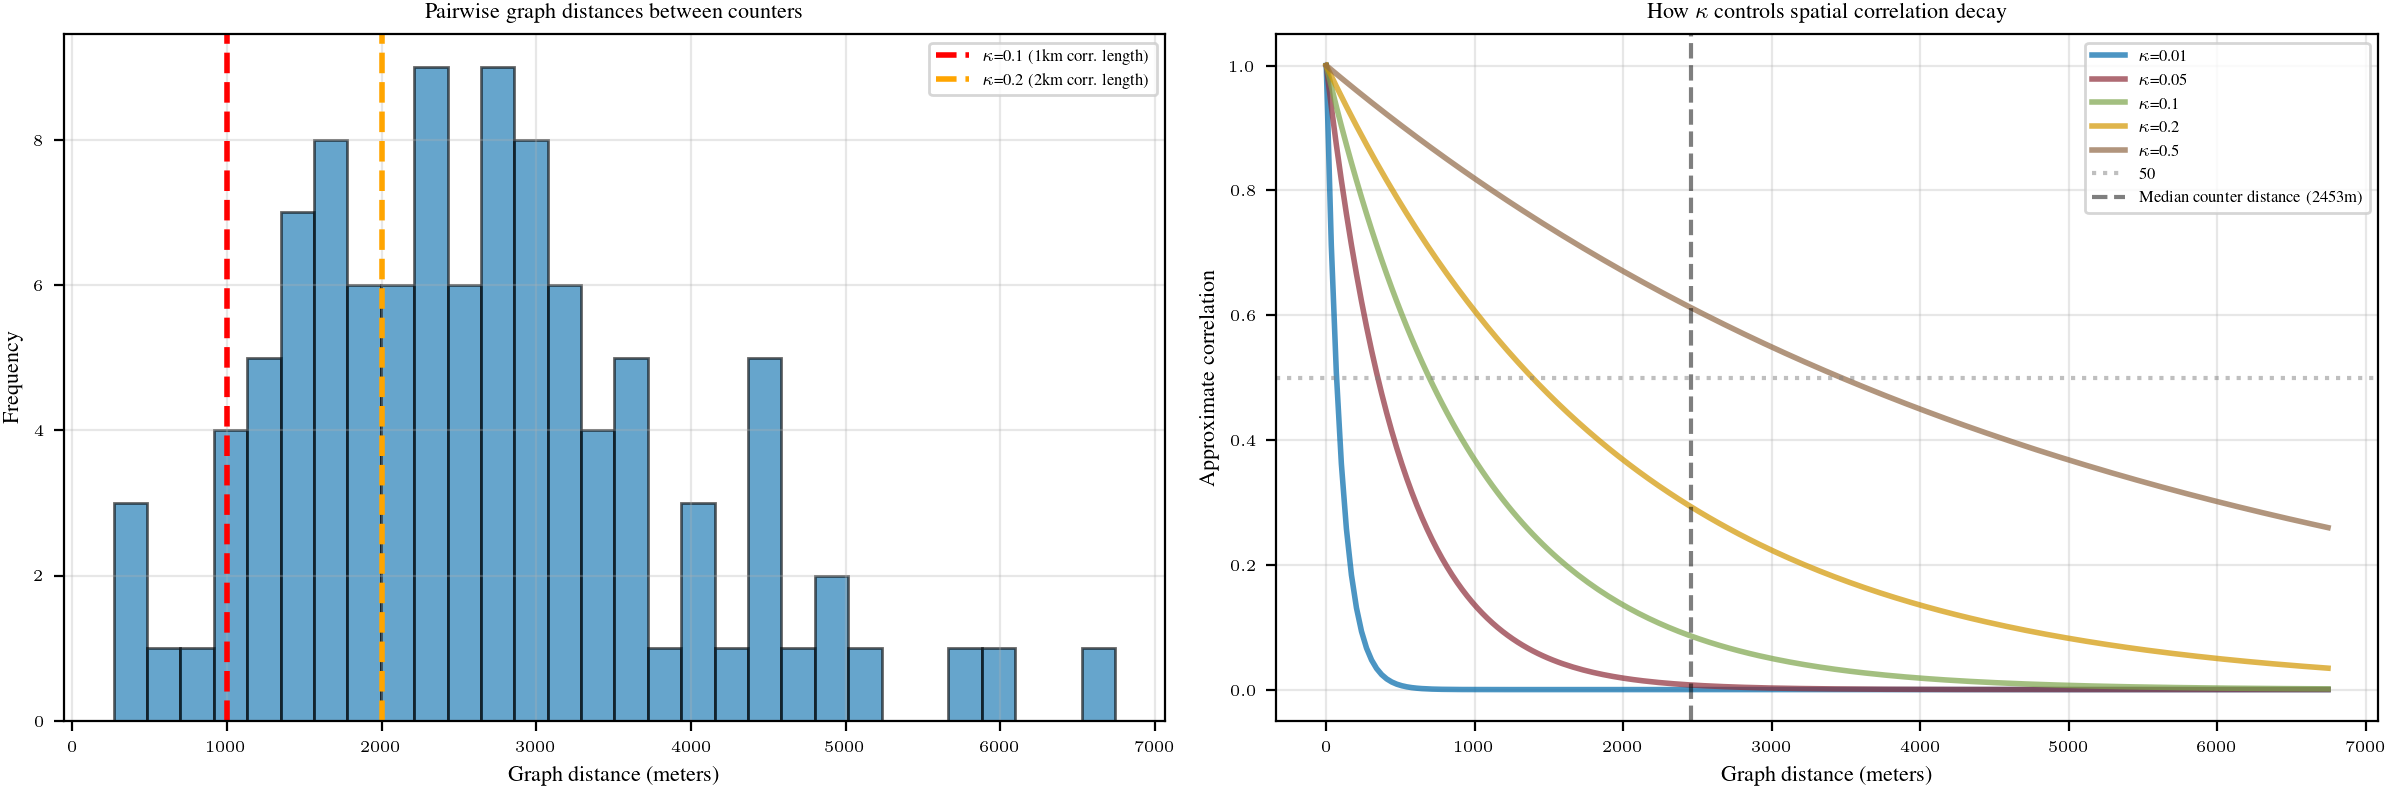


Interpretation:
With kappa = 0.1:
  - Counters ~1 km apart have moderate correlation
  - Median counter spacing: 2453 m
  - This means counters are typically close enough to share
    spatial information about bike traffic patterns

With kappa = 0.01:
  - Only very nearby counters (<100m) are correlated
  - Most counter pairs too far apart to share information
  - Model becomes nearly independent per counter

With kappa = 0.5:
  - Even distant counters (>5 km) remain highly correlated
  - Risk of over-smoothing spatial variation
  - All predictions become too similar


In [21]:
# Visualize the relationship between kappa and correlation decay
with plt.rc_context(get_style(rel_width=1.0)):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # Left: Graph distance histogram with kappa interpretations
    ax1.hist(graph_distances, bins=30, alpha=0.6, edgecolor='black')
    ax1.axvline(1000, color='red', linestyle='--', linewidth=2, label=r'$\kappa$=0.1 (1km corr. length)')
    ax1.axvline(2000, color='orange', linestyle='--', linewidth=2, label=r'$\kappa$=0.2 (2km corr. length)')
    ax1.set_xlabel('Graph distance (meters)')
    ax1.set_ylabel('Frequency')
    ax1.set_title('Pairwise graph distances between counters')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Right: Kernel values as function of distance for different kappa
    distances = np.linspace(0, graph_distances.max(), 200)
    kappas_to_plot = [0.01, 0.05, 0.1, 0.2, 0.5]
    
    for kappa_val in kappas_to_plot:
        # Approximate correlation: for diffusion kernel on graph
        # correlation approx exp(-distance / length_scale)
        # where length_scale is related to kappa
        corr = np.exp(-distances / (1000 * kappa_val * 10))  # rough approximation
        ax2.plot(distances, corr, label=rf'$\kappa$={kappa_val}', linewidth=2)
    
    ax2.axhline(0.5, color='gray', linestyle=':', alpha=0.5, label='50% correlation')
    ax2.axvline(np.median(graph_distances), color='black', linestyle='--', alpha=0.5, 
                label=f'Median counter distance ({np.median(graph_distances):.0f}m)')
    ax2.set_xlabel('Graph distance (meters)')
    ax2.set_ylabel('Approximate correlation')
    ax2.set_title(r'How $\kappa$ controls spatial correlation decay')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.show()

print("\nInterpretation:")
print("="*60)
print(f"With kappa = 0.1:")
print(f"  - Counters ~1 km apart have moderate correlation")
print(f"  - Median counter spacing: {np.median(graph_distances):.0f} m")
print(f"  - This means counters are typically close enough to share")
print(f"    spatial information about bike traffic patterns")
print(f"\nWith kappa = 0.01:")
print(f"  - Only very nearby counters (<100m) are correlated")
print(f"  - Most counter pairs too far apart to share information")
print(f"  - Model becomes nearly independent per counter")
print(f"\nWith kappa = 0.5:")
print(f"  - Even distant counters (>5 km) remain highly correlated")
print(f"  - Risk of over-smoothing spatial variation")
print(f"  - All predictions become too similar")

In [22]:
from itertools import combinations

# map: index in array -> original node id
idx_to_node = {i: n for n, i in node_to_idx.items()}

# shortest-path distances from each training node to all other nodes
train_dists = []

for tn_idx in train_node_idx:
    node_id = idx_to_node[tn_idx]
    
    d = nx.single_source_dijkstra_path_length(
        G,
        node_id,
        weight="length"  
    )
    train_dists.append(d)

all_node_idx = np.array([node_to_idx[n] for n in node_xy["node_id"]], dtype=int)
min_dist_to_train = np.array([
    min(train_dists[i].get(idx_to_node[idx], np.inf) for i in range(len(train_node_idx)))
    for idx in all_node_idx
])
print("min/max distance to nearest training counter:", min_dist_to_train.min(), min_dist_to_train.max())

# Collect all results
cv_results = []

# Get node indices for observed counters only (not all graph nodes)
obs_node_idx = np.array([node_to_idx[n] for n in df_obs["node_id"]], dtype=int)

# Get all combinations
n_obs = len(df_obs)
all_combinations = list(combinations(range(n_obs), 2))
n_combinations = len(all_combinations)

print(f"Starting leave-two-out cross-validation")
print(f"Total observed counters: {n_obs}")
print(f"Number of leave-two-out combinations: {n_combinations}")
print(f"{'='*80}\n")

# Iterate over all leave-two-out combinations
for combo_idx, (test_idx1, test_idx2) in enumerate(all_combinations, 1):
    if combo_idx % 10 == 0 or combo_idx == 1:
        print(f"Processing combination {combo_idx}/{n_combinations} - Testing nodes {test_idx1}, {test_idx2}")
    
    # Create train/test split
    test_mask = np.zeros(n_obs, dtype=bool)
    test_mask[test_idx1] = True
    test_mask[test_idx2] = True
    train_mask = ~test_mask
    
    train_node_idx_cv = obs_node_idx[train_mask]
    test_node_idx_cv = obs_node_idx[test_mask]
    
    # Get training and test data
    y_train_cv = df_obs.loc[train_mask, 'y_x'].values
    y_test_cv = df_obs.loc[test_mask, 'y_x'].values
    
    # Standardize based on training data
    y_mean_cv = y_train_cv.mean()
    y_std_cv = y_train_cv.std()
    y_train_std_cv = (y_train_cv - y_mean_cv) / y_std_cv
    y_test_std_cv = (y_test_cv - y_mean_cv) / y_std_cv
    
    # ------------------------------------------
    # EUCLIDEAN GP
    # ------------------------------------------
    X_train_cv = df_obs.loc[train_mask, ['x', 'y_y']].values
    X_test_cv = df_obs.loc[test_mask, ['x', 'y_y']].values
    
    # Train Euclidean GP
    gp_euc_cv = GaussianProcessRegressor(
        kernel=kernel_euc,
        alpha=0.0,
        normalize_y=True,
        n_restarts_optimizer=5,
        random_state=RANDOM_SEED
    )
    gp_euc_cv.fit(X_train_cv, y_train_std_cv)
    
    # Predict on test set
    pred_mean_euc_cv, pred_std_euc_cv = gp_euc_cv.predict(X_test_cv, return_std=True)
    
    # Unstandardize predictions
    pred_mean_euc_cv = pred_mean_euc_cv * y_std_cv + y_mean_cv
    pred_std_euc_cv = pred_std_euc_cv * y_std_cv
    
    # Calculate metrics for Euclidean GP
    mae_euc_cv = mean_absolute_error(y_test_cv, pred_mean_euc_cv)
    rmse_euc_cv = np.sqrt(mean_squared_error(y_test_cv, pred_mean_euc_cv))
    mape_euc_cv = np.mean(np.abs((y_test_cv - pred_mean_euc_cv) / y_test_cv)) * 100
    
    # Calculate log likelihood for each test point (Euclidean GP)
    log_lik_euc_1 = -0.5 * np.log(2 * np.pi) - np.log(pred_std_euc_cv[0]) - 0.5 * ((y_test_cv[0] - pred_mean_euc_cv[0]) / pred_std_euc_cv[0])**2
    log_lik_euc_2 = -0.5 * np.log(2 * np.pi) - np.log(pred_std_euc_cv[1]) - 0.5 * ((y_test_cv[1] - pred_mean_euc_cv[1]) / pred_std_euc_cv[1])**2
    log_lik_euc_avg = (log_lik_euc_1 + log_lik_euc_2) / 2
    
    # ------------------------------------------
    # GRAPH GP (with hyperparameter optimization)
    # ------------------------------------------
    # Define bounds for CV optimization (in log-space)
    bounds_cv = [
        (np.log(0.001), np.log(0.5)),   # kappa: 0.001 to 0.5
        (np.log(0.01), np.log(5.0))     # noise: 0.01 to 5.0
    ]
    
    # Optimize kappa and noise for this CV fold
    def nll_kappa_noise_cv(log_params):
        log_kappa, log_noise = log_params
        kappa_cv = np.exp(log_kappa)
        noise_cv = np.exp(log_noise)
        
        Z_cv = build_Z(kappa_cv, sigma2_fixed)
        Ztr_cv_opt = Z_cv[train_node_idx_cv, :]
        
        K_cv = Ztr_cv_opt @ Ztr_cv_opt.T
        K_cv[np.diag_indices_from(K_cv)] += noise_cv**2 + 1e-8
        
        try:
            L_cv = la.cholesky(K_cv, lower=True, check_finite=False)
        except la.LinAlgError:
            return np.inf
        
        alpha_cv = la.cho_solve((L_cv, True), y_train_std_cv, check_finite=False)
        
        n = len(y_train_std_cv)
        nll = 0.5 * (y_train_std_cv @ alpha_cv) + np.sum(np.log(np.diag(L_cv))) + 0.5 * n * np.log(2*np.pi)
        return float(nll)
    
    # Test sensitivity to kappa (first fold only)
    if combo_idx == 1:
        test_kappas = [0.01, 0.05, 0.1, 0.2, 0.3]
        test_nlls = [nll_kappa_noise_cv(np.log([k, 0.5])) for k in test_kappas]
        print(f"\n  NLL sensitivity to kappa (noise=0.5 fixed):")
        for k, nll in zip(test_kappas, test_nlls):
            print(f"    kappa={k:.3f}: NLL={nll:.4f}")
        
        # Test sensitivity to noise (kappa=0.1 fixed)
        test_noises = [0.1, 0.3, 0.5, 1.0, 2.0]
        test_nlls_noise = [nll_kappa_noise_cv(np.log([0.1, n])) for n in test_noises]
        print(f"\n  NLL sensitivity to noise (kappa=0.1 fixed):")
        for n, nll in zip(test_noises, test_nlls_noise):
            print(f"    noise={n:.3f}: NLL={nll:.4f}")
        print()
    
    # Optimize hyperparameters with bounds
    res_cv = minimize(nll_kappa_noise_cv, x0=np.log([0.1, 0.5]), method="L-BFGS-B", bounds=bounds_cv, options={"maxiter": 500})
    kappa_cv, noise_cv = np.exp(res_cv.x)
    
    # Diagnostic info for first combination to verify optimization is working
    if combo_idx == 1:
        print(f"\n  Optimization diagnostics (first fold):")
        print(f"    Success: {res_cv.success}")
        print(f"    Message: {res_cv.message}")
        print(f"    Iterations: {res_cv.nit}")
        print(f"    Final NLL: {res_cv.fun:.4f}")
        print(f"    Optimized kappa: {kappa_cv:.6f}")
        print(f"    Optimized noise: {noise_cv:.6f}\n")
    
    # Build Z with optimized kappa
    Z_cv = build_Z(kappa_cv, sigma2_fixed)
    Ztr_cv = Z_cv[train_node_idx_cv, :]
    Zte_cv = Z_cv[test_node_idx_cv, :]
    
    # Compute kernel matrices with optimized parameters
    Ktr_cv = Ztr_cv @ Ztr_cv.T
    Kte_tr_cv = Zte_cv @ Ztr_cv.T
    
    # Cholesky decomposition with optimized noise
    Ktr_noise_cv = Ktr_cv + (noise_cv**2) * np.eye(len(train_node_idx_cv))
    L_cv = la.cholesky(Ktr_noise_cv, lower=True)
    
    # Solve for alpha
    alpha_cv = la.cho_solve((L_cv, True), y_train_std_cv)
    
    # Predict mean
    pred_mean_graph_cv = Kte_tr_cv @ alpha_cv
    
    # Predict variance
    v_cv = la.solve_triangular(L_cv, Kte_tr_cv.T, lower=True)
    Kte_diag_cv = np.sum(Zte_cv**2, axis=1)
    pred_var_graph_cv = Kte_diag_cv - np.sum(v_cv**2, axis=0)
    # pred_std_graph_cv = np.sqrt(np.maximum(pred_var_graph_cv, 0) + noise_cv**2)
    pred_std_graph_cv = np.sqrt(pred_var_graph_cv + noise_cv**2)  # Add observation noise!
    
    # Unstandardize predictions
    pred_mean_graph_cv = pred_mean_graph_cv * y_std_cv + y_mean_cv
    pred_std_graph_cv = pred_std_graph_cv * y_std_cv
    
    # Calculate metrics for Graph GP
    mae_graph_cv = mean_absolute_error(y_test_cv, pred_mean_graph_cv)
    rmse_graph_cv = np.sqrt(mean_squared_error(y_test_cv, pred_mean_graph_cv))
    mape_graph_cv = np.mean(np.abs((y_test_cv - pred_mean_graph_cv) / y_test_cv)) * 100
    
    # Calculate log likelihood for each test point (Graph GP)
    log_lik_graph_1 = -0.5 * np.log(2 * np.pi) - np.log(pred_std_graph_cv[0]) - 0.5 * ((y_test_cv[0] - pred_mean_graph_cv[0]) / pred_std_graph_cv[0])**2
    log_lik_graph_2 = -0.5 * np.log(2 * np.pi) - np.log(pred_std_graph_cv[1]) - 0.5 * ((y_test_cv[1] - pred_mean_graph_cv[1]) / pred_std_graph_cv[1])**2
    log_lik_graph_avg = (log_lik_graph_1 + log_lik_graph_2) / 2
    
    # Store results
    cv_results.append({
        'test_idx1': test_idx1,
        'test_idx2': test_idx2,
        'test_node1': idx_to_node[test_node_idx_cv[0]],
        'test_node2': idx_to_node[test_node_idx_cv[1]],
        'y_true1': y_test_cv[0],
        'y_true2': y_test_cv[1],
        # Euclidean GP metrics
        'mae_euc': mae_euc_cv,
        'rmse_euc': rmse_euc_cv,
        'mape_euc': mape_euc_cv,
        'pred_mean_euc1': pred_mean_euc_cv[0],
        'pred_mean_euc2': pred_mean_euc_cv[1],
        'pred_std_euc1': pred_std_euc_cv[0],
        'pred_std_euc2': pred_std_euc_cv[1],
        'log_lik_euc_1': log_lik_euc_1,
        'log_lik_euc_2': log_lik_euc_2,
        'log_lik_euc_avg': log_lik_euc_avg,
        # Graph GP metrics
        'mae_graph': mae_graph_cv,
        'rmse_graph': rmse_graph_cv,
        'mape_graph': mape_graph_cv,
        'pred_mean_graph1': pred_mean_graph_cv[0],
        'pred_mean_graph2': pred_mean_graph_cv[1],
        'pred_std_graph1': pred_std_graph_cv[0],
        'pred_std_graph2': pred_std_graph_cv[1],
        'log_lik_graph_1': log_lik_graph_1,
        'log_lik_graph_2': log_lik_graph_2,
        'log_lik_graph_avg': log_lik_graph_avg,
        # Graph GP hyperparameters
        'kappa_graph': kappa_cv,
        'noise_graph': noise_cv
    })

# Convert to DataFrame
df_cv_results = pd.DataFrame(cv_results)

print(f"\n{'='*80}")
print("Leave-Two-Out Cross-Validation Complete")
print(f"{'='*80}\n")

# Summary statistics
print("EUCLIDEAN GP:")
print(f"  Mean MAE:  {df_cv_results['mae_euc'].mean():.4f} ± {df_cv_results['mae_euc'].std():.4f}")
print(f"  Mean RMSE: {df_cv_results['rmse_euc'].mean():.4f} ± {df_cv_results['rmse_euc'].std():.4f}")
print(f"  Mean MAPE: {df_cv_results['mape_euc'].mean():.2f}% ± {df_cv_results['mape_euc'].std():.2f}%")
print(f"  Mean Log Likelihood: {df_cv_results['log_lik_euc_avg'].mean():.4f} ± {df_cv_results['log_lik_euc_avg'].std():.4f}")

print("\nGRAPH GP:")
print(f"  Mean MAE:  {df_cv_results['mae_graph'].mean():.4f} ± {df_cv_results['mae_graph'].std():.4f}")
print(f"  Mean RMSE: {df_cv_results['rmse_graph'].mean():.4f} ± {df_cv_results['rmse_graph'].std():.4f}")
print(f"  Mean MAPE: {df_cv_results['mape_graph'].mean():.2f}% ± {df_cv_results['mape_graph'].std():.2f}%")
print(f"  Mean Log Likelihood: {df_cv_results['log_lik_graph_avg'].mean():.4f} ± {df_cv_results['log_lik_graph_avg'].std():.4f}")

print("\nCOMPARISON (Graph - Euclidean):")
print(f"  Δ MAE:  {df_cv_results['mae_graph'].mean() - df_cv_results['mae_euc'].mean():.4f}")
print(f"  Δ RMSE: {df_cv_results['rmse_graph'].mean() - df_cv_results['rmse_euc'].mean():.4f}")
print(f"  Δ MAPE: {df_cv_results['mape_graph'].mean() - df_cv_results['mape_euc'].mean():.2f}%")
print(f"  Δ Log Likelihood: {df_cv_results['log_lik_graph_avg'].mean() - df_cv_results['log_lik_euc_avg'].mean():.4f}")

print("\nGRAPH GP HYPERPARAMETERS:")
print(f"  κ (kappa):     {df_cv_results['kappa_graph'].mean():.4f} ± {df_cv_results['kappa_graph'].std():.4f}")
print(f"  noise (σ_n):   {df_cv_results['noise_graph'].mean():.4f} ± {df_cv_results['noise_graph'].std():.4f}")

# Display first few results
print(f"\nFirst 5 combinations:")
print(df_cv_results.head())

min/max distance to nearest training counter: 0.0 4087.626879753161
Starting leave-two-out cross-validation
Total observed counters: 15
Number of leave-two-out combinations: 105

Processing combination 1/105 - Testing nodes 0, 1

  NLL sensitivity to kappa (noise=0.5 fixed):
    kappa=0.010: NLL=27.0798
    kappa=0.050: NLL=27.0798
    kappa=0.100: NLL=27.0798
    kappa=0.200: NLL=27.0799
    kappa=0.300: NLL=27.0801

  NLL sensitivity to noise (kappa=0.1 fixed):
    noise=0.100: NLL=184.3837
    noise=0.300: NLL=53.8097
    noise=0.500: NLL=27.0798
    noise=1.000: NLL=18.4652
    noise=2.000: NLL=22.6212


  Optimization diagnostics (first fold):
    Success: True
    Message: CONVERGENCE: NORM OF PROJECTED GRADIENT <= PGTOL
    Iterations: 6
    Final NLL: 18.4631
    Optimized kappa: 0.099998
    Optimized noise: 0.986975

Processing combination 10/105 - Testing nodes 0, 10


/opt/anaconda3/envs/lit/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Processing combination 20/105 - Testing nodes 1, 7


/opt/anaconda3/envs/lit/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Processing combination 30/105 - Testing nodes 2, 5


/opt/anaconda3/envs/lit/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Processing combination 40/105 - Testing nodes 3, 4


/opt/anaconda3/envs/lit/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/anaconda3/envs/lit/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/anaconda3/envs/lit/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/anaconda3/envs/lit/lib/python3.12/site-packages/sklearn/

Processing combination 50/105 - Testing nodes 3, 14


/opt/anaconda3/envs/lit/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Processing combination 60/105 - Testing nodes 4, 14
Processing combination 70/105 - Testing nodes 6, 7


/opt/anaconda3/envs/lit/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/anaconda3/envs/lit/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/anaconda3/envs/lit/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/anaconda3/envs/lit/lib/python3.12/site-packages/sklearn/

Processing combination 80/105 - Testing nodes 7, 10


/opt/anaconda3/envs/lit/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/anaconda3/envs/lit/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/anaconda3/envs/lit/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Processing combination 90/105 - Testing nodes 8, 14


/opt/anaconda3/envs/lit/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/anaconda3/envs/lit/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/anaconda3/envs/lit/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Processing combination 100/105 - Testing nodes 11, 12


/opt/anaconda3/envs/lit/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(



Leave-Two-Out Cross-Validation Complete

EUCLIDEAN GP:
  Mean MAE:  35.6582 ± 16.7714
  Mean RMSE: 39.7410 ± 18.2236
  Mean MAPE: 85.45% ± 51.18%
  Mean Log Likelihood: -5.4366 ± 1.1007

GRAPH GP:
  Mean MAE:  34.0118 ± 18.2954
  Mean RMSE: 38.4946 ± 20.1819
  Mean MAPE: 81.42% ± 52.00%
  Mean Log Likelihood: -5.3531 ± 0.9910

COMPARISON (Graph - Euclidean):
  Δ MAE:  -1.6464
  Δ RMSE: -1.2464
  Δ MAPE: -4.03%
  Δ Log Likelihood: 0.0836

GRAPH GP HYPERPARAMETERS:
  κ (kappa):     0.1000 ± 0.0000
  noise (σ_n):   0.9930 ± 0.0031

First 5 combinations:
   test_idx1  test_idx2  test_node1  test_node2  y_true1  y_true2    mae_euc  \
0          0          1   272590518  9512032494     24.0    150.0  59.769525   
1          0          2   272590518   271705119     24.0     60.0  18.670815   
2          0          3   272590518   135036403     24.0     58.0  26.567399   
3          0          4   272590518  5165758557     24.0    141.0  54.782147   
4          0          5   272590518   2694

Cross-validation results saved to: /Users/davidsuckrow/Documents/Developing/Data Literacy/fahrradzaehler/outputs/plots/GP/cross_validation/leave_two_out_cv_Stadt_Ludwigsburg.csv


<>:37: SyntaxWarning: invalid escape sequence '\%'
<>:38: SyntaxWarning: invalid escape sequence '\%'
<>:76: SyntaxWarning: invalid escape sequence '\%'
<>:37: SyntaxWarning: invalid escape sequence '\%'
<>:38: SyntaxWarning: invalid escape sequence '\%'
<>:76: SyntaxWarning: invalid escape sequence '\%'
/var/folders/dn/vxwn6zk17qg5wl81t01zs03w0000gn/T/ipykernel_3096/3129916145.py:37: SyntaxWarning: invalid escape sequence '\%'
  ax3.set_xlabel('MAPE Euclidean GP (\%)')
/var/folders/dn/vxwn6zk17qg5wl81t01zs03w0000gn/T/ipykernel_3096/3129916145.py:38: SyntaxWarning: invalid escape sequence '\%'
  ax3.set_ylabel('MAPE Graph GP (\%)')
/var/folders/dn/vxwn6zk17qg5wl81t01zs03w0000gn/T/ipykernel_3096/3129916145.py:76: SyntaxWarning: invalid escape sequence '\%'
  ax3.set_xlabel('MAPE (\%)')
/var/folders/dn/vxwn6zk17qg5wl81t01zs03w0000gn/T/ipykernel_3096/3129916145.py:43: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


Comparison plot saved to: /Users/davidsuckrow/Documents/Developing/Data Literacy/fahrradzaehler/outputs/plots/GP/cross_validation/cv_comparison_Stadt_Ludwigsburg.pdf


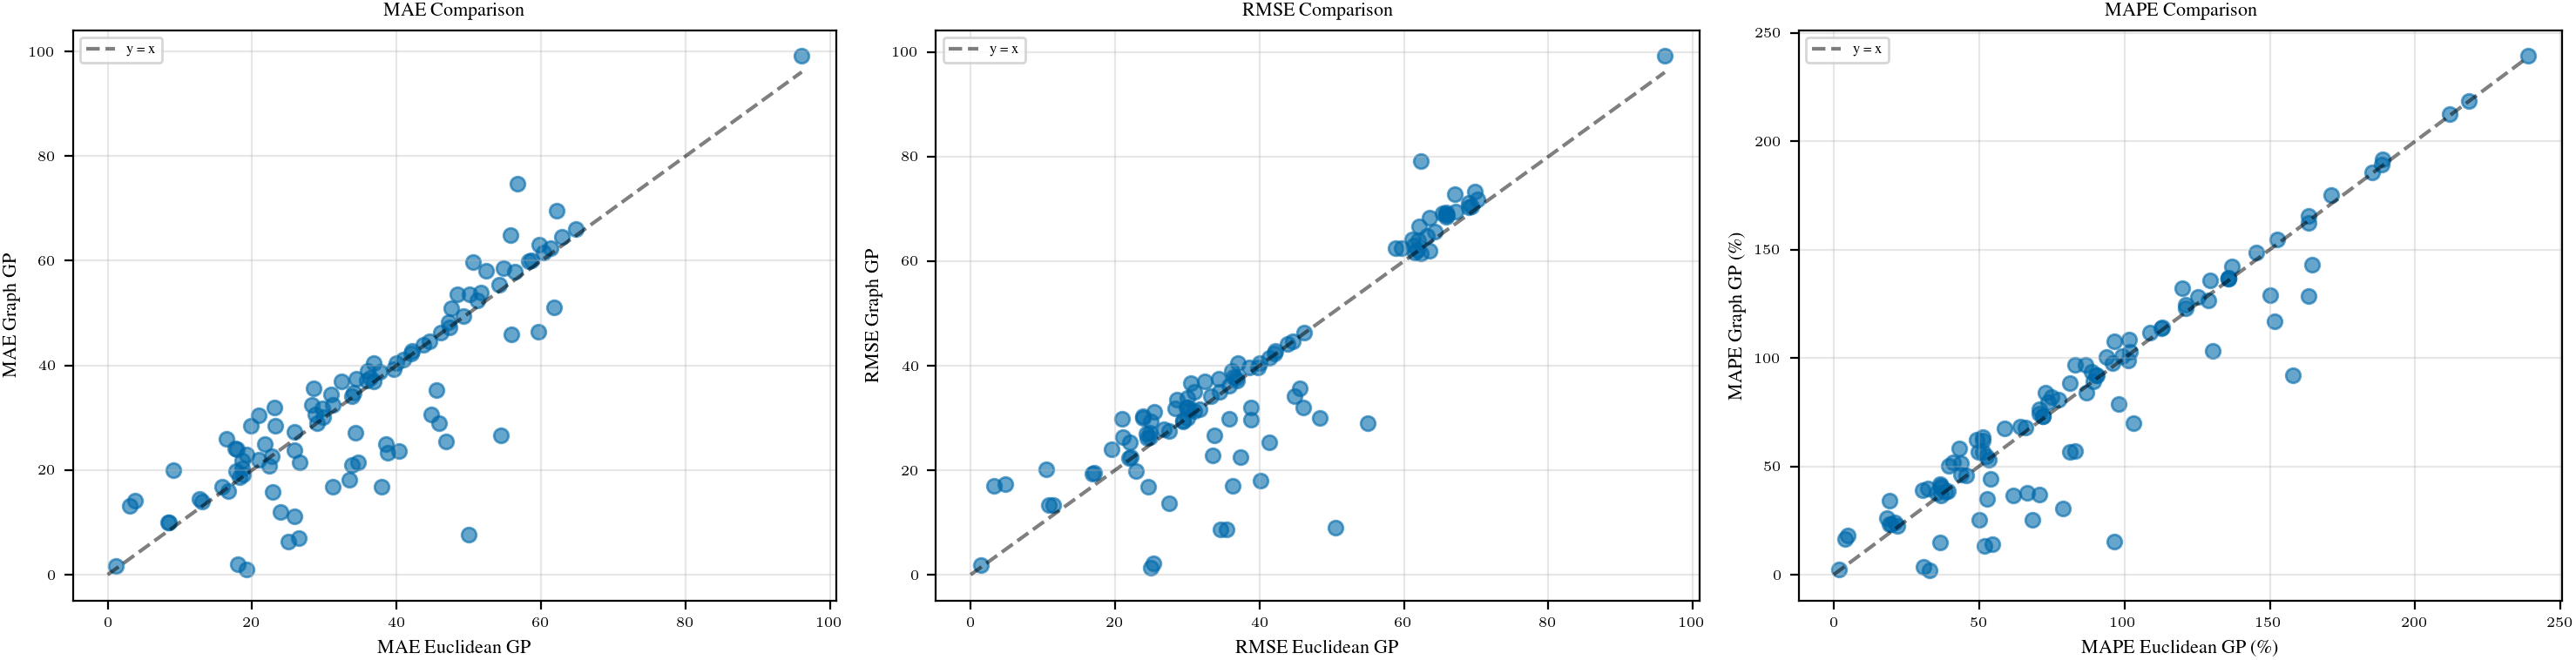

/var/folders/dn/vxwn6zk17qg5wl81t01zs03w0000gn/T/ipykernel_3096/3129916145.py:82: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


Distribution plot saved to: /Users/davidsuckrow/Documents/Developing/Data Literacy/fahrradzaehler/outputs/plots/GP/cross_validation/cv_distributions_Stadt_Ludwigsburg.pdf


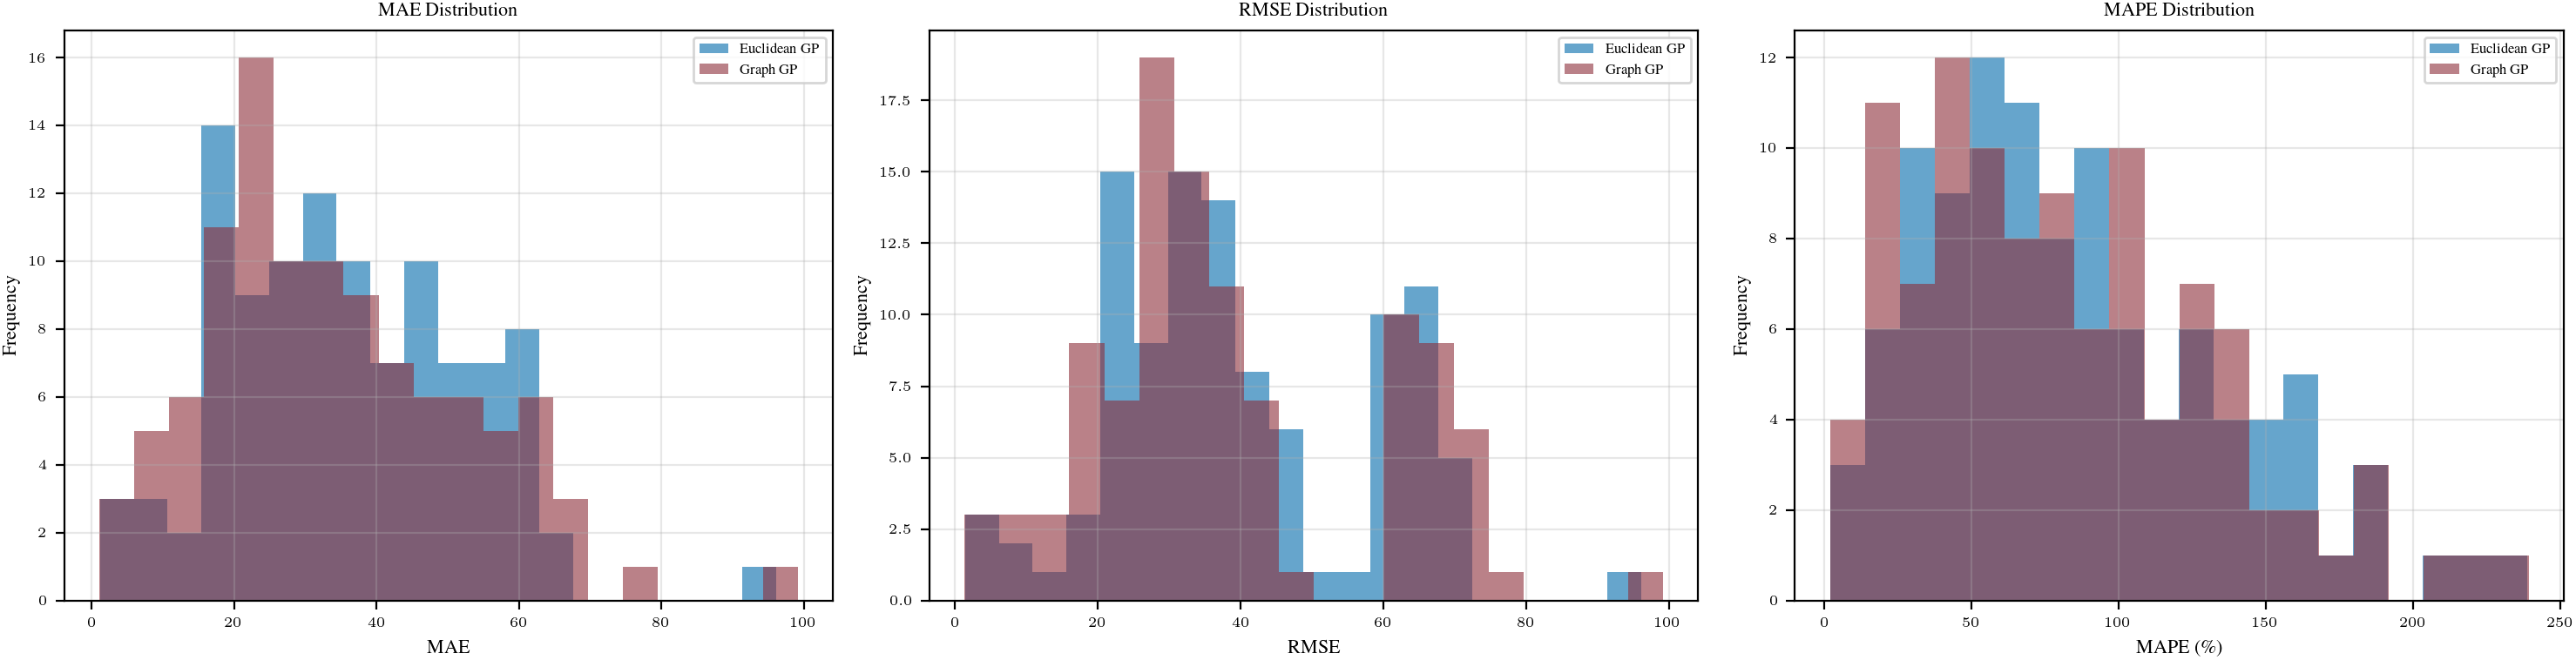

In [23]:
# Save cross-validation results to CSV
cv_output_dir = OUTPUT_DIR / "cross_validation"
cv_output_dir.mkdir(parents=True, exist_ok=True)

cv_results_path = cv_output_dir / f"leave_two_out_cv_{DOMAIN.replace(' ', '_')}.csv"
df_cv_results.to_csv(cv_results_path, index=False)
print(f"Cross-validation results saved to: {cv_results_path}")

# Create visualization comparing Euclidean vs Graph GP
with plt.rc_context(get_style(rel_width=1.0, font_adjustment=0, display_dpi=200, ncols=3)):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
    
    # MAE comparison
    ax1.scatter(df_cv_results['mae_euc'], df_cv_results['mae_graph'], alpha=0.6)
    ax1.plot([0, df_cv_results['mae_euc'].max()], [0, df_cv_results['mae_euc'].max()], 
             'k--', alpha=0.5, label='y = x')
    ax1.set_xlabel('MAE Euclidean GP')
    ax1.set_ylabel('MAE Graph GP')
    ax1.set_title('MAE Comparison')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # RMSE comparison
    ax2.scatter(df_cv_results['rmse_euc'], df_cv_results['rmse_graph'], alpha=0.6)
    ax2.plot([0, df_cv_results['rmse_euc'].max()], [0, df_cv_results['rmse_euc'].max()], 
             'k--', alpha=0.5, label='y = x')
    ax2.set_xlabel('RMSE Euclidean GP')
    ax2.set_ylabel('RMSE Graph GP')
    ax2.set_title('RMSE Comparison')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # MAPE comparison
    ax3.scatter(df_cv_results['mape_euc'], df_cv_results['mape_graph'], alpha=0.6)
    ax3.plot([0, df_cv_results['mape_euc'].max()], [0, df_cv_results['mape_euc'].max()], 
             'k--', alpha=0.5, label='y = x')
    ax3.set_xlabel('MAPE Euclidean GP (\%)')
    ax3.set_ylabel('MAPE Graph GP (\%)')
    ax3.set_title('MAPE Comparison')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # Save plot
    plot_path = cv_output_dir / f"cv_comparison_{DOMAIN.replace(' ', '_')}.pdf"
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    print(f"Comparison plot saved to: {plot_path}")
    plt.show()

# Distribution plots
with plt.rc_context(get_style(rel_width=1.0, font_adjustment=0, display_dpi=200, ncols=3)):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
    
    # MAE distributions
    ax1.hist(df_cv_results['mae_euc'], bins=20, alpha=0.6, label='Euclidean GP')
    ax1.hist(df_cv_results['mae_graph'], bins=20, alpha=0.6, label='Graph GP')
    ax1.set_xlabel('MAE')
    ax1.set_ylabel('Frequency')
    ax1.set_title('MAE Distribution')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # RMSE distributions
    ax2.hist(df_cv_results['rmse_euc'], bins=20, alpha=0.6, label='Euclidean GP')
    ax2.hist(df_cv_results['rmse_graph'], bins=20, alpha=0.6, label='Graph GP')
    ax2.set_xlabel('RMSE')
    ax2.set_ylabel('Frequency')
    ax2.set_title('RMSE Distribution')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # MAPE distributions
    ax3.hist(df_cv_results['mape_euc'], bins=20, alpha=0.6, label='Euclidean GP')
    ax3.hist(df_cv_results['mape_graph'], bins=20, alpha=0.6, label='Graph GP')
    ax3.set_xlabel('MAPE (\%)')
    ax3.set_ylabel('Frequency')
    ax3.set_title('MAPE Distribution')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # Save plot
    plot_path = cv_output_dir / f"cv_distributions_{DOMAIN.replace(' ', '_')}.pdf"
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    print(f"Distribution plot saved to: {plot_path}")
    plt.show()

In [24]:
# print all MAEs from df_cv_results
print("All MAEs from leave-two-out cross-validation:")
print("Combination | MAE Euclidean GP | MAE Graph GP | RMSE Euclidean GP | RMSE Graph GP")
for idx, row in df_cv_results.iterrows():
    print(f"{idx+1:11d} | {row['mae_euc']:.4f}          | {row['mae_graph']:.4f} | {row['rmse_euc']:.4f}          | {row['rmse_graph']:.4f}")


All MAEs from leave-two-out cross-validation:
Combination | MAE Euclidean GP | MAE Graph GP | RMSE Euclidean GP | RMSE Graph GP
          1 | 59.7695          | 63.0144 | 69.2892          | 70.4972
          2 | 18.6708          | 20.3287 | 24.7808          | 27.1572
          3 | 26.5674          | 21.5487 | 27.5288          | 27.4107
          4 | 54.7821          | 58.5107 | 61.1647          | 64.1958
          5 | 18.7026          | 19.1695 | 24.2847          | 26.9989
          6 | 44.5385          | 44.5505 | 44.6394          | 44.6501
          7 | 45.4888          | 35.3056 | 45.5597          | 35.6583
          8 | 34.3884          | 37.4752 | 34.3888          | 37.5363
          9 | 42.1246          | 42.8244 | 42.1955          | 42.8501
         10 | 28.7426          | 30.7009 | 29.9777          | 31.9988
         11 | 29.0000          | 28.9420 | 29.9832          | 29.9488
         12 | 34.2516          | 27.1763 | 35.8529          | 29.7416
         13 | 40.0257          |

In [25]:
# Find the CV combination that matches the original train/test split
original_test_nodes = set(test_df["node_id"].values)
original_test_indices = test_df.index.tolist()

print("Original test split:")
print(f"  Test node IDs: {original_test_nodes}")
print(f"  Test indices in df_obs: {original_test_indices}")
print(f"  Test counter sites: {test_df['counter_site'].tolist()}")
print(f"\nOriginal metrics (from earlier in notebook):")
print(f"  Euclidean GP: RMSE={rmse_euc:.3f}, MAE={mae_euc:.3f}")
print(f"  Graph GP:     RMSE={rmse_graph:.3f}, MAE={mae_graph:.3f}")

# Find matching combination in CV results
matching_cv = None
for idx, row in df_cv_results.iterrows():
    cv_test_nodes = {row['test_node1'], row['test_node2']}
    if cv_test_nodes == original_test_nodes:
        matching_cv = row
        print(f"\nFound matching CV combination at index {idx}:")
        print(f"  Test indices: ({row['test_idx1']}, {row['test_idx2']})")
        print(f"  Test nodes: {cv_test_nodes}")
        print(f"  Euclidean GP: RMSE={row['rmse_euc']:.3f}, MAE={row['mae_euc']:.3f}")
        print(f"  Graph GP:     RMSE={row['rmse_graph']:.3f}, MAE={row['mae_graph']:.3f}")
        break

if matching_cv is None:
    print("\nNo matching combination found in CV results!")
    print("This might happen if df_obs order changed between runs.")

Original test split:
  Test node IDs: {np.int64(269466187), np.int64(9006691822)}
  Test indices in df_obs: [5, 7]
  Test counter sites: ['Fuchshof', 'Königinallee']

Original metrics (from earlier in notebook):
  Euclidean GP: RMSE=16.851, MAE=13.036
  Graph GP:     RMSE=19.390, MAE=14.016

Found matching CV combination at index 61:
  Test indices: (5.0, 7.0)
  Test nodes: {np.float64(269466187.0), np.float64(9006691822.0)}
  Euclidean GP: RMSE=16.851, MAE=13.036
  Graph GP:     RMSE=19.390, MAE=14.016
